In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc

plt.rc('axes', axisbelow=True)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tc-hard/notebooks/notebooks.classification/results/"
FIGURE_BASE = f"/home/{login}/Git/tc-hard/notebooks/notebooks.classification-results/figures/"

In [7]:
metrics = [
    'AUROC',
    'Accuracy',
    'Recall',
    'Precision',
    'F1 score',
    'AUPR'
]

def pr_auc(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    return pr_auc

def get_scores(y_true, y_prob, y_pred):
    """
    Compute a df with all classification metrics and respective scores.
    """
    
    scores = [
        roc_auc_score(y_true, y_prob),
        accuracy_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        pr_auc(y_true, y_prob)
    ]
    
    df = pd.DataFrame(data={'score': scores, 'metrics': metrics})
    return df

In [8]:
def get_scores_per_pep(df, model = None, setting = None):
    df_list = []
    for p in sorted(df['antigen.epitope'].unique()):
        temp = df[df['antigen.epitope'] == p]
        scores_pep_pep = get_scores(temp.label, temp.prediction, temp.prediction.round())
        scores_pep_pep['pep'] = p
        df_list.append(scores_pep_pep)
        
    df = pd.concat(df_list)

    if model:
        df["Model"] = model
    if setting:
        df["Setting"] = model+' | '+setting
        
    return df

In [9]:
# we consider split 0
nettc2_f_h = pd.read_csv(DATA_BASE+"nettcr2.pep+cdr3b+cdr3a+mhc.full.hard-split.0.csv")
nettc2_ns_h = pd.read_csv(DATA_BASE+"nettcr2.pep+cdr3b+cdr3a+mhc.only-sampled-negs.hard-split.0.csv")
ergo2_f_h = pd.read_csv(DATA_BASE+"ergo2.pep+cdr3b+cdr3a+mhc.full.hard-split.0.csv")
ergo2_ns_h = pd.read_csv(DATA_BASE+"ergo2.pep+cdr3b+cdr3a+mhc.only-sampled-negs.hard-split.0.csv")

ergo2_f_h = ergo2_f_h.rename(columns={'Peptide': 'antigen.epitope', 'sign': 'label'})
ergo2_ns_h = ergo2_ns_h.rename(columns={'Peptide': 'antigen.epitope', 'sign': 'label'})

In [10]:
pep_pep_results = pd.concat([
    get_scores_per_pep(nettc2_f_h, model = "NetTCR-2.0", setting = 'Train: RN+NA'),
    get_scores_per_pep(nettc2_ns_h, model = "NetTCR-2.0", setting = 'Train: RN'),
    get_scores_per_pep(ergo2_f_h, model = "ERGO II", setting = 'Train: RN+NA'),
    get_scores_per_pep(ergo2_ns_h, model = "ERGO II", setting = 'Train: RN'),
])
pep_pep_results = pep_pep_results.rename(columns={'score': 'Score', 'metrics': 'Metrics', 'pep': 'Peptide'})

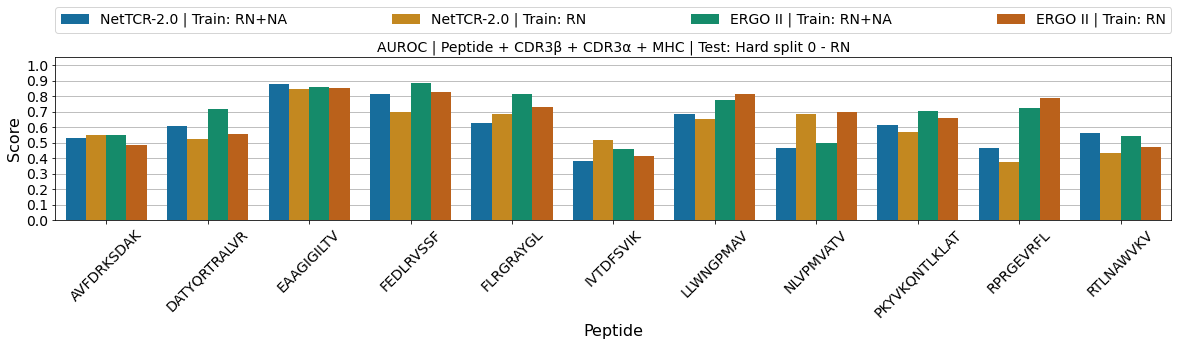

In [11]:
auroc_df = pep_pep_results[pep_pep_results.Metrics == 'AUROC']

plt.rcParams['figure.figsize'] = [20, 3]

ax = sns.barplot(
    x="Peptide",
    y="Score", 
    hue="Setting", 
    data=auroc_df,
    palette=sns.color_palette("colorblind", 4)
)
ax.set_title('AUROC | Peptide + CDR3β + CDR3α + MHC | Test: Hard split 0 - RN')
legend = plt.legend(bbox_to_anchor=(0,1.15,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
frame = legend.get_frame()
frame.set_facecolor('white')
ax.grid(axis='y')
plt.yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim([0, 1.05])
plt.xticks(rotation = 45)

plt.savefig(FIGURE_BASE + "auroc.per-pep.pep+cdr3b+cdr3a+mhc.hard-split-0.png", format='png', dpi=300, bbox_inches='tight')

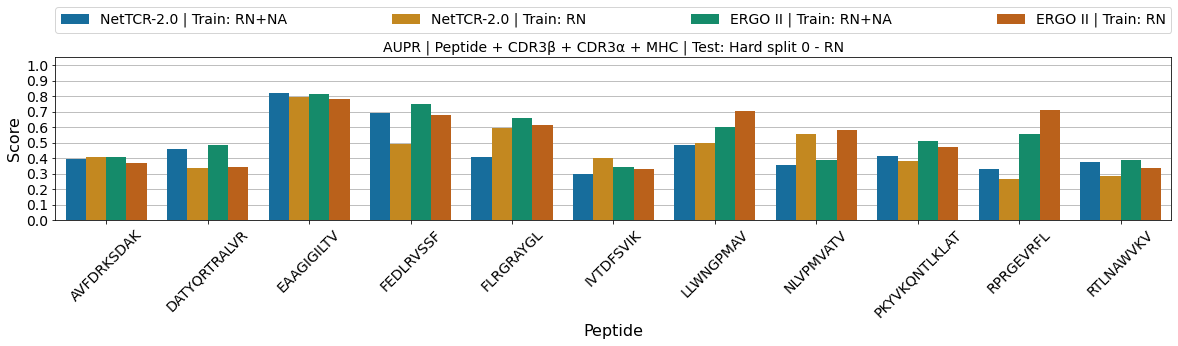

In [14]:
aupr_df = pep_pep_results[pep_pep_results.Metrics == 'AUPR']

plt.rcParams['figure.figsize'] = [20, 3]

ax = sns.barplot(
    x="Peptide",
    y="Score", 
    hue="Setting", 
    data=aupr_df,
    palette=sns.color_palette("colorblind", 4)
)
ax.set_title('AUPR | Peptide + CDR3β + CDR3α + MHC | Test: Hard split 0 - RN')
legend = plt.legend(bbox_to_anchor=(0,1.15,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
frame = legend.get_frame()
frame.set_facecolor('white')
ax.grid(axis='y')
plt.yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim([0, 1.05])
plt.xticks(rotation = 45)

plt.savefig(FIGURE_BASE + "aupr.per-pep.pep+cdr3b+cdr3a+mhc.hard-split-0.png", format='png', dpi=300, bbox_inches='tight')